In [42]:

import os,sys,inspect
currentdir = os.path.abspath(inspect.getfile(inspect.currentframe()))
parentdir = os.path.dirname(currentdir)
rootdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir) 
sys.path.insert(0,rootdir) 

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

import analysis
import utils
import plot

import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


In [43]:
# Load pairwise distance matrices and associated graphs
vocab, wd_pw, img_pw, G_wd, G_img = utils.load_graphs_and_pw(q=0.1, dist_type="eu")


### Forced choice plots

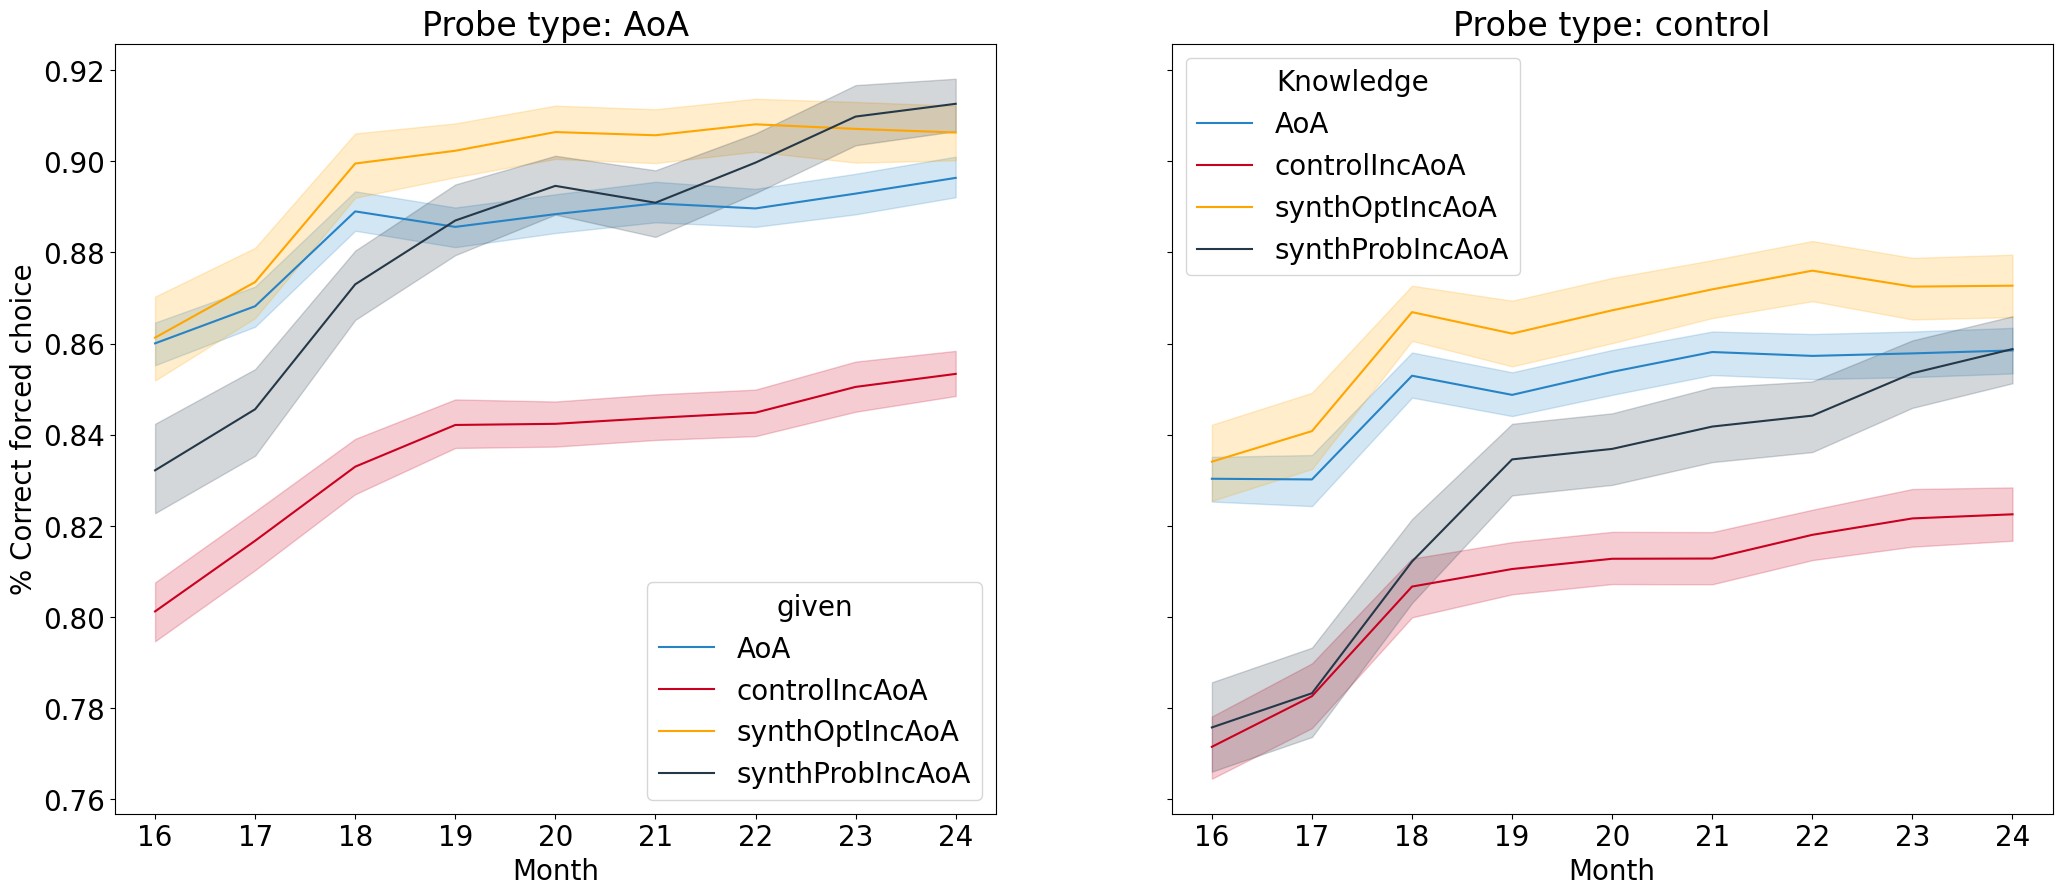

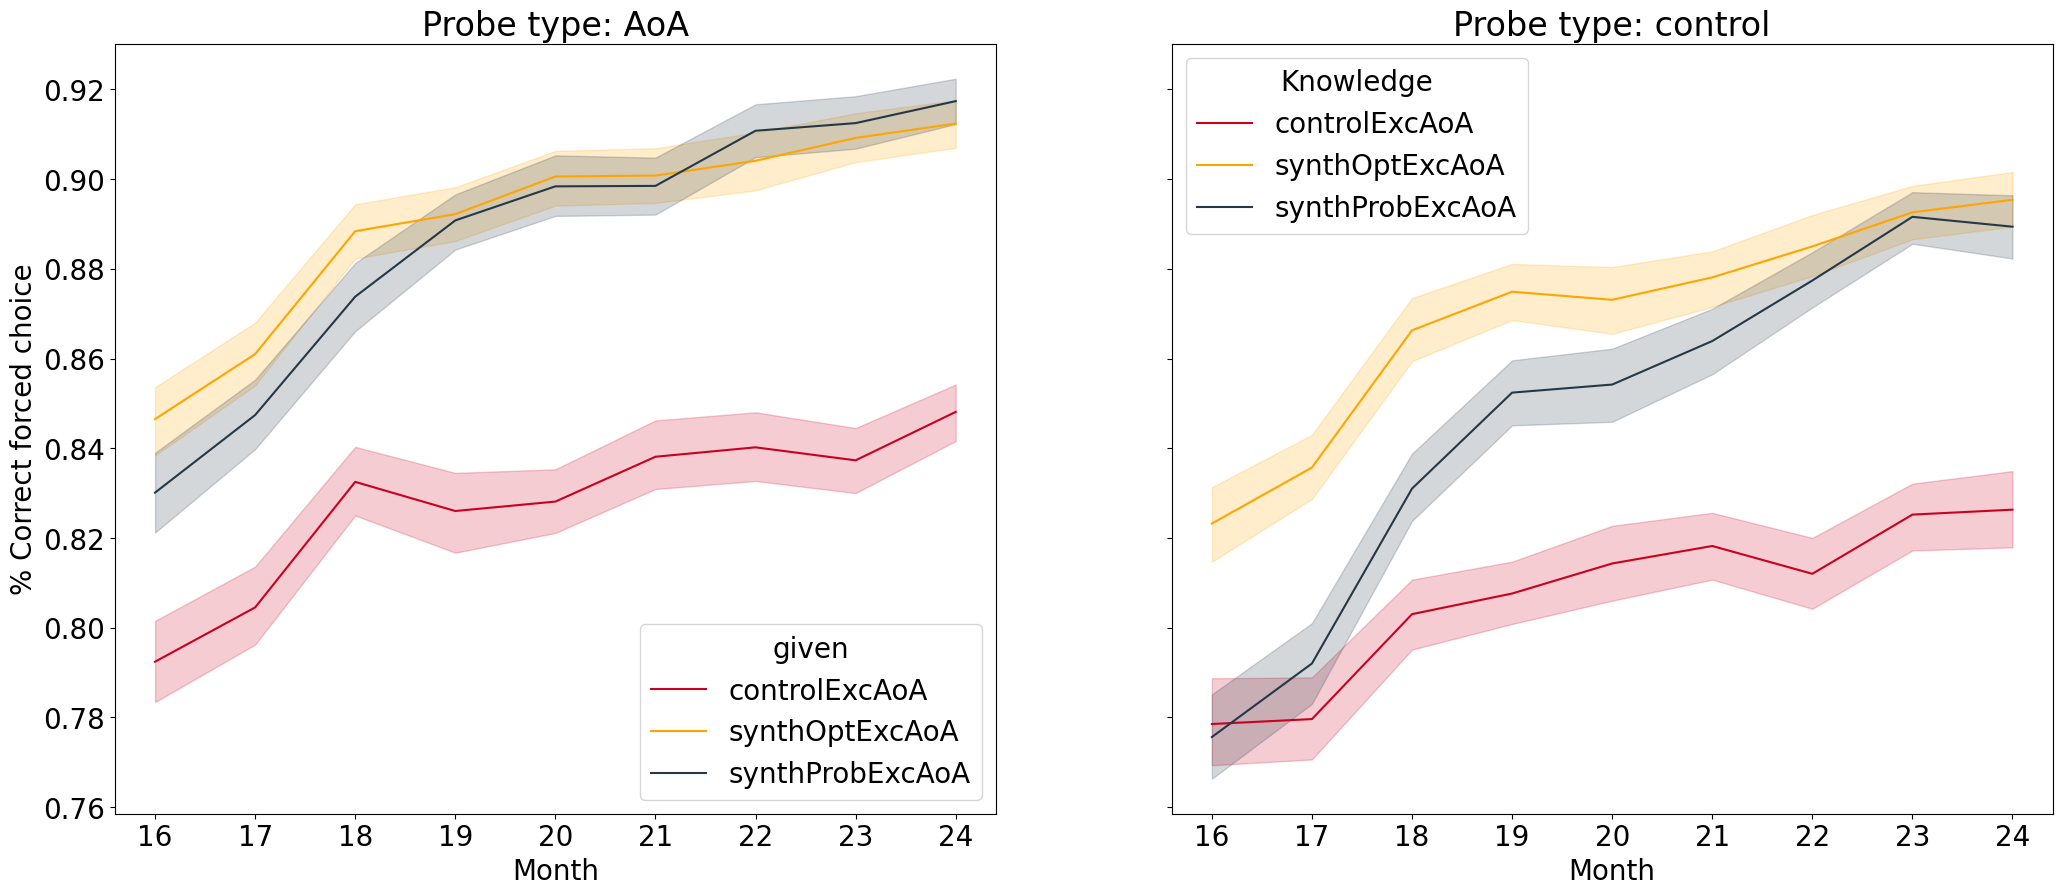

In [44]:
pp0 = pd.read_csv(
            "../results/probe_pair/probe_pair_optimal.csv",
            header=0, index_col=0)
pp1 = pd.read_csv(
            "../results/probe_pair/probe_pair_probmatch.csv",
            header=0, index_col=0)
pp2 = pd.read_csv(
            "../results/probe_pair/probe_pair_emp.csv",
            header=0, index_col=0)

pps = pd.concat([
                pp0,
                pp1,
                pp2
                ])

conditions = ["controlIncAoA", 
             "synthOptIncAoA",
             "synthProbIncAoA", 
             "AoA"] 

plot.probeExpt_results_shady(pps, conditions=conditions,
                fn="../results/probe_pair/probe_pair_include_optinc.png",
                months=[x for x in range(16, 25)],
                probe_conds=["AoA", "control"])
        
conditions = ["controlExcAoA", 
             "synthOptExcAoA",
             "synthProbExcAoA"] 

plot.probeExpt_results_shady(pps, conditions=conditions,
                fn="../results/probe_pair/probe_pair_include_exclude.png",
                months=[x for x in range(16, 25)],
                probe_conds=["AoA", "control"])


### Load sample sequences for regression

In [45]:


df1 = pd.read_csv("../results/seq_features/sequence_non_nx_mets_monthwise.csv",
                  header=0, index_col=0)

df2 = pd.read_csv("../results/seq_features/sequence_nx_mets_monthwise.csv",
                  header=0, index_col=0)
df2 = df2[[x for x in df2.columns
                               if ("25" not in x) & ("50" not in x)]]

sample_mets = df1.merge(
                    df2, on=["condition", "pid", "month"]
                ).drop_duplicates()

# Average measures across modalities
sample_mets = analysis.get_modality_averages(sample_mets)

# Get only modality agnostic cols
sample_mets = sample_mets[
        [x for x in sample_mets.columns
         if ("_1" not in x) and ("_2" not in x)]
        ]

sample_mets = sample_mets.loc[sample_mets["month"]<=24]

sample_mets = sample_mets[[x for x in sample_mets.columns if "rel" not in x]]
sample_mets = sample_mets[sample_mets["condition"] != "controlIncAoA"]


In [46]:
# Input into regression model framework for selection of best vars

sample_mets["given_cat"] = [x == "AoA" for x in sample_mets["condition"]]

X = sample_mets.drop(
    columns=["month", "pid", "condition", "given_cat"]
    + [x for x in sample_mets.columns
        if "acq" in x]
    + [x for x in sample_mets.columns
        if "1" in x or "2" in x] # Remove modality specific features
    + [x for x in sample_mets.columns
        if ("clustering" in x)|("betweenness" in x)] # Remove for high correlation with degree; high computational cost
    + [x for x in sample_mets.columns
        if (("max" in x) or ("min" in x) and ("deg" in x))] # Remove for high correlations
    + [x for x in sample_mets.columns
        if ("skew" in x) & ("dist" in x)] # Remove for high correlations
                    ) 

#X = X.drop(columns=["n_given"])
y_bin = sample_mets["given_cat"]


In [47]:
rs=50

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y_bin,
                                                    test_size=0.2,
                                                    random_state=0
                                                    )
# Range of n selected features to test
rng = [x for x in range(1, len(X.columns) + 1)]

# Collect scores to compare values of n
aics = []
bics = []
selected_vars = []

# Cycle through values of n
for n_feat in rng:
    # Input to feature selector
    model = LogisticRegression(
                                penalty="l2",
                                solver="liblinear",
                                max_iter=100000,
                                random_state=rs
                              )

    # Feature selector
    selector = RFE(
                    model,
                    n_features_to_select=n_feat,
                    step=1
                   )

    selector.fit(X_train, y_train)

    selected_names = [X_train.columns[i]
                      for i, x in enumerate(selector.support_)
                      if x
                     ]
    selected_vars.append(selected_names)


    # Predict using constructed model
    preds = selector.predict(X_test)

    # Gather metrics for model comparison
    loglik = analysis.calculate_logprob(
        selector, X_test, np.expand_dims(y_test, 1)
        )
    aic = analysis.calculate_aic(len(selected_names), loglik)
    bic = analysis.calculate_bic(len(selected_names), X_train.shape[0], loglik)
    bics.append(bic)
    aics.append(aic)
    

model_df = pd.DataFrame(
                {"n_vars":rng,
                 "bic":bics,
                 "aic":aics,
                 "vars":selected_vars}
            )

# Select best model
best_N = rng[np.argmin(aics)]
print("Best N: ", best_N)

# Construct best model
model = LogisticRegression(penalty="l2",
                           solver="liblinear",
                           max_iter=100000,
                           random_state=rs
                          )

selector = RFE(
                model,
                n_features_to_select=best_N,
                step=1
                )

selector.fit(X_train, y_train)

selected_names = [X_train.columns[i]
                  for i, x in enumerate(selector.support_)
                  if x
                 ]

model = LogisticRegression(penalty="l2",
                           solver="liblinear",
                           max_iter=100000,
                           random_state=rs
                          )

model.fit(X_train[selected_names], y_train)

preds = model.predict(X_test[selected_names])

print(dict(
            zip(
                selected_names,
                [x for x in model.coef_[0] if x != 0]
            )
        ))

acc = accuracy_score(y_test, preds)
recall= recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1 = f1_score(y_test, preds)
print("accuracy: {}, f1: {}, recall: {}, precision: {}".format(
            acc, f1, recall, precision
        ))


Best N:  7
{'min_dist_full': -2.6048240581492235, 'min_dist_subs': -4.035775810540676, 'mean_dist_subs': -3.276663737379201, 'mean_deg_full': 5.355413600465027, 'mean_deg_subs': 7.208966564269812, 'deg_skew_subs': 4.75617731608624, 'coverage': -7.425069498163995}
accuracy: 0.9527777777777777, f1: 0.9558441558441558, recall: 0.989247311827957, precision: 0.9246231155778895


### Plotting model fit results

In [48]:
# Load in all results for restarts

matchprob = pd.DataFrame({})
optimal = pd.DataFrame({})

for r in range(5):

    if r not in [0]: # Filter out restarts which fell into local minima
        mp1 = pd.read_csv(
            f"../results/model_training/probMatch_results_{r}.csv", 
                header=0, index_col=0)
        matchprob = pd.concat([matchprob, mp1])
        
    o1= pd.read_csv(f"../results/model_training/optimal_results_{r}.csv", 
                    header=0, index_col=0)
    optimal = pd.concat([optimal, o1])

matchprob["condition"] = "structural-matchAoA"
optimal["condition"] = "structural-optimal"



In [49]:
from scipy.special import expit

get_restarts = "all"
#get_restarts = "best"

vs = pd.DataFrame({})

num_vars = [
            "degree_subs",
            "degree_full",
            "mean_dist_subs",
            "coverage",
            "min_dist_full",
            "min_dist_subs",
            "degree_skew_subs",
            #"degree_skew_full",
            "val_loss"
            ]

for restarts in [matchprob, optimal]:
    
    restarts = restarts.astype(
                                dict(
                                    zip(
                                        num_vars,
                                        ["float32"]*len(num_vars))
                                    )
                                )

    headers = pd.DataFrame(columns=[
                                "pid", "condition", 
                                "month", "concept", 
                                "concept_id", "aoa",
                                "acq_idx", "restart"
                                ])

    cond_dict = {
        "sample":{
            True: "synthExcAoA", False:"synthIncAoA"
            },
        "mode":{
            True: "ExcAoA", False:"IncAoA"
        }
    }
    

    # Pick the restart with the lowest final validation loss
    min_loss = restarts.loc[
            restarts['epoch'] >= restarts['epoch'].max() - 5 # Check performance over last 5 epochs
        ][["restart", "val_loss"]].groupby(
            "restart"
        ).agg(
            "mean"
        ).reset_index()
    
    if get_restarts == "best":
        re = min_loss.loc[
            min_loss["val_loss"] == min_loss["val_loss"].min(), "restart"
            ].iloc[0]
        res = restarts.loc[restarts["restart"] == re]
    elif get_restarts == "all":
        res = restarts
        
    # Process weights column
    res["linear_comb"] = analysis.clean_linear_comb(res["linear_comb"])
    
    for v in num_vars:
        if v != "val_loss":
            res[v] = expit(res[v])
    vs = pd.concat([vs, res])
    

In [50]:
# Get final param values and corresponding weights in one df
pl = vs.loc[(vs["epoch"] == 99)
            & 
            (vs["month"] == vs["month"].max())
           ]

pl = pl[num_vars +  ["restart", "condition", "epoch", "month"]].melt(
            id_vars=["condition", "epoch", "month", "restart"],
            var_name="variable"
        )
pl = pl.drop_duplicates()

# Get weights in columns
w = vs.loc[(vs["epoch"] == 99)
            & 
            (vs["month"] == vs["month"].max())
           ]

w = w[["condition", "linear_comb", "restart"]]
w[num_vars[:-1]] = w["linear_comb"].str.split(
                                        ',',expand=True
                                        )
w = w.drop(columns = "linear_comb")
w = w.melt(
            id_vars=["condition", "restart"],
            var_name="variable",
            value_name="weight")
w["weight"] = w["weight"].astype("float")
w["weight"] = np.round(np.exp(w["weight"]), 2)


pl = pl.merge(w, on=["condition", "restart", "variable"])

pl["style"] = [
                "reference"
                if y in ["aoa", "random"]
                else "learned params"
                for y in pl["condition"]
               ]


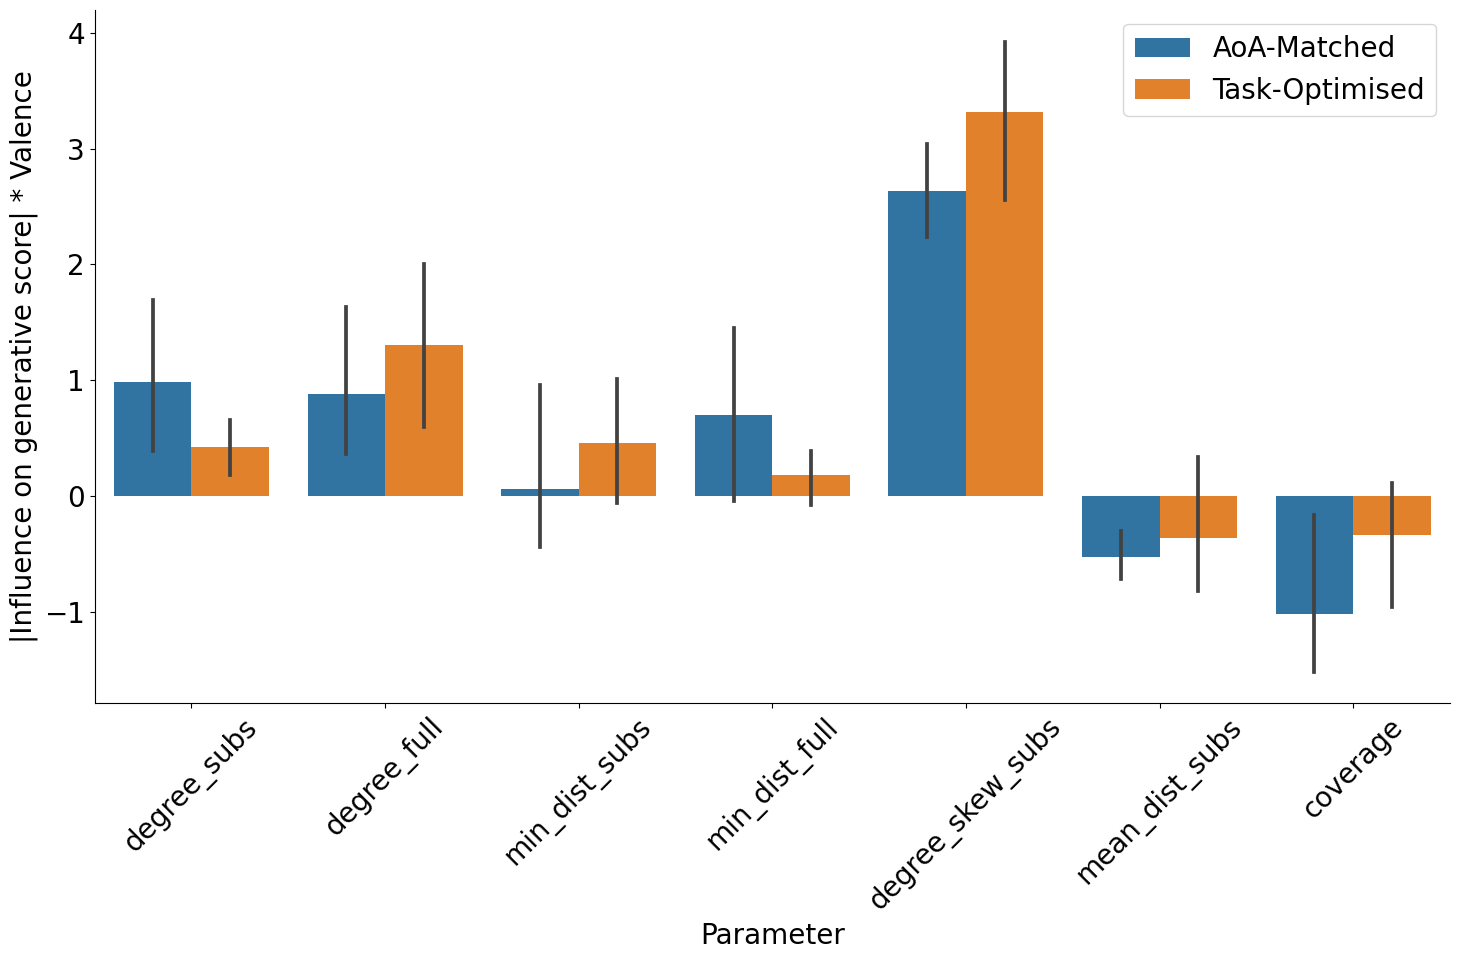

In [51]:
### Get reference values from control samples
# Get diffs from targ value for each random sample
smets2 = sample_mets[
                    ["condition", "pid"] + [
                        "mean_deg_subs", "mean_deg_full",
                        "mean_dist_subs", "coverage",
                        "min_dist_full", "min_dist_subs",
                        "deg_skew_subs", "deg_skew_full"]
                    ]

smets2 = smets2.rename(columns={
                                "mean_deg_full":"degree_full",
                                "mean_deg_subs":"degree_subs",
                                "deg_skew_subs":"degree_skew_subs",
                                #"deg_skew_full":"degree_skew_full",
                            })

smets2 = smets2.melt(id_vars=["condition", "pid"])
smets2["condition"] = [
                        "aoa"
                        if x == "AoA"
                        else "random"
                        for x in smets2["condition"]
                      ]
smets2.columns = ["condition", "pid", "variable", "value"]
smets2 = smets2.loc[smets2["condition"] == "random"]


pl_w = pl[
            ["condition",
             "variable",
             "value",
             "weight",
             "restart"]
        ]

pl_w = pl_w.merge(
                    smets2[["variable", "value", "pid"]],
                    on=["variable"]
                 )
pl_w = pl_w.rename(columns={"variable":"parameter"})


# Get mean difference from each target var
pl_w["diff"] = pl_w["value_x"] - pl_w["value_y"]
pl_w = pl_w[
            ["condition",
             "parameter",
             "value_x",
             "weight",
             "diff", 
             "restart"]
        ].groupby(
            ["condition",
             "restart",
             "parameter"]
        ).agg("mean")

pl_w = pl_w.reset_index()
pl_w.columns = ["condition", "restart",
                "parameter", "value",
                "weight", "diff"]

pl_w["influence"] = pl_w["weight"] * pl_w["diff"]
pl_w = pl_w.rename(
            columns={"condition_x":"condition"}
            )

n_d = {
    "structural-matchAoA":"AoA-Matched",
    "structural-optimal":"Task-Optimised"
}
pl_w["condition"] = [n_d[x] for x in pl_w["condition"]]

norm = plt.Normalize(pl_w.influence.min(), pl_w.influence.max())



g = sns.catplot(x="parameter", hue="condition", y="influence", data=pl_w,
                kind="bar",
                order=[
                        "degree_subs", "degree_full",
                        "min_dist_subs", "min_dist_full",
                        "degree_skew_subs", 
                        "mean_dist_subs", "coverage"],
                height=10, aspect=1.5, legend=None)
g.axes.flat[0].set_ylabel("|Influence on generative score| * Valence")
g.axes.flat[0].set_xlabel("Parameter")

plt.xticks(rotation=45)

plt.legend(loc="upper right")
plt.close(2)    # close empty figure
plt.ylabel("|Influence on generative score| * Valence")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("Figures/learned_param_values.png")



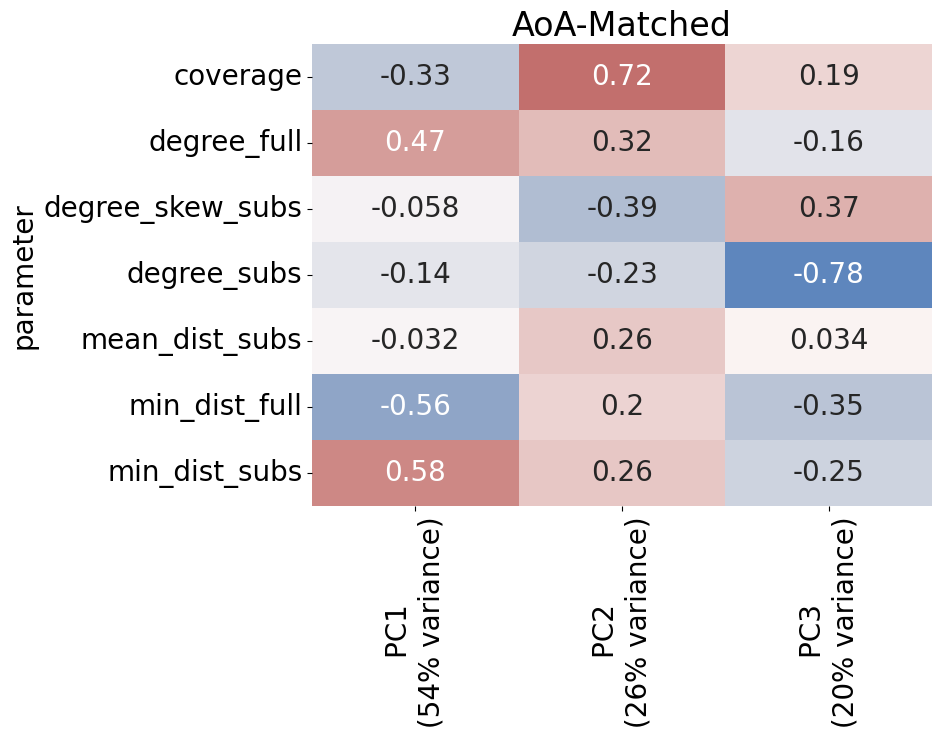

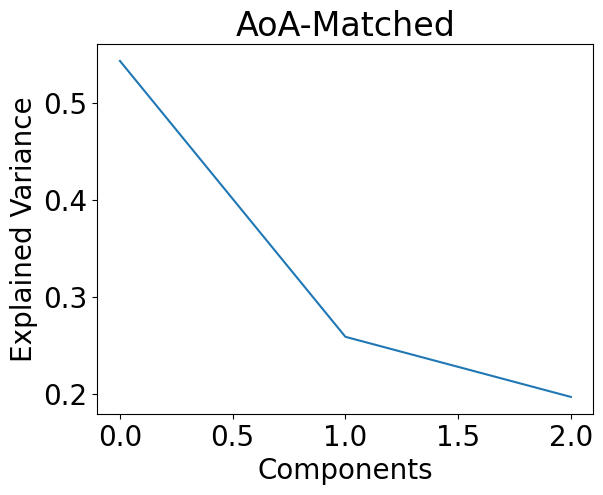

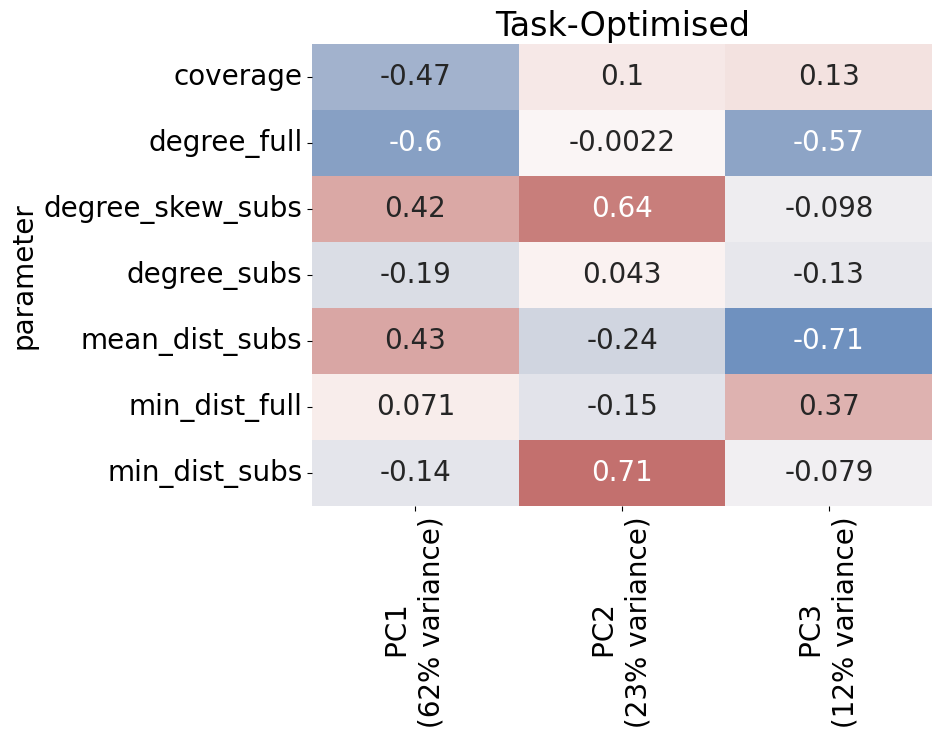

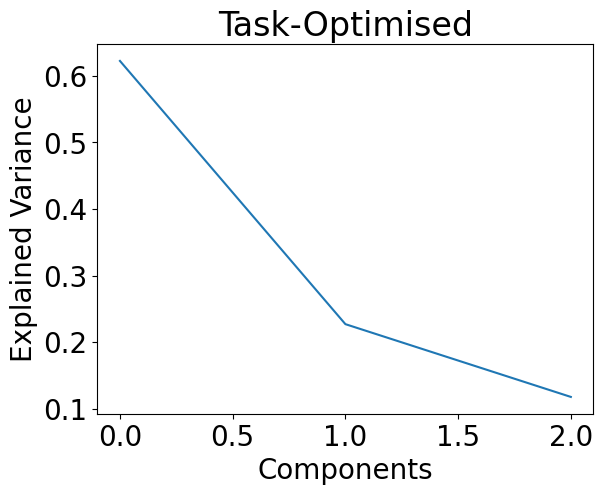

In [63]:
## Correlation analysis or PCA
from sklearn.decomposition import PCA

plt.rcParams['font.size'] = '20'
for c in pl_w.condition.unique():

    p_f = pl_w.loc[pl_w["condition"] == c][["restart","parameter","influence"]]
    p_f = p_f.pivot(index="restart", columns="parameter", values="influence")

    pca = PCA(n_components=3)
    pca.fit(p_f)

    # Reformat and view results
    plt.figure(figsize=(8,6))
    loadings = pd.DataFrame(pca.components_.T,
                            index=p_f.columns)
    sns.heatmap(loadings, vmin=-1, vmax=1, annot=True, cbar=False,
                xticklabels=[
                    "PC{0} \n ({1:.0%} variance)".format(
                        i+1, pca.explained_variance_ratio_[i]
                    ) for i in range(3)], cmap="vlag")
    plt.title(c)
    plt.savefig("{}_principcal_comps.png".format(c), bbox_inches="tight")
    
    plt.show()
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance')
    plt.xlabel('Components')
    plt.title(c)
    plt.show()



### Examine generated sequences

In [53]:
#### Repeat these analyses, but for the partitioned data
# Compare the structural to the optimal agent
labels = {
        "controlIncAoA": "Control",
        "AoA": "AoA",
        "synthProbIncAoA": "matchAoA",
        "synthOptIncAoA": "taskOptimised"
}

all_seqs = pd.DataFrame({})


df_aoa = pd.read_csv(
        "../results/sample_sequences/AoA_sequences.csv")
                
df_control = pd.read_csv(
        "../results/sample_sequences/controlIncAoA_sequences.csv")

df_optimal = pd.read_csv(
        "../results/sample_sequences/synthOptIncAoA_sequences.csv")

df_structural = pd.read_csv(
        "../results/sample_sequences/synthProbIncAoA_sequences.csv"
                       )

all_seqs = pd.concat([df_aoa, df_control, df_optimal, df_structural])

all_seqs["condition"] = [labels[x] for x in all_seqs["condition"]]
    
all_seqs = all_seqs.loc[all_seqs["month"] <= 24]

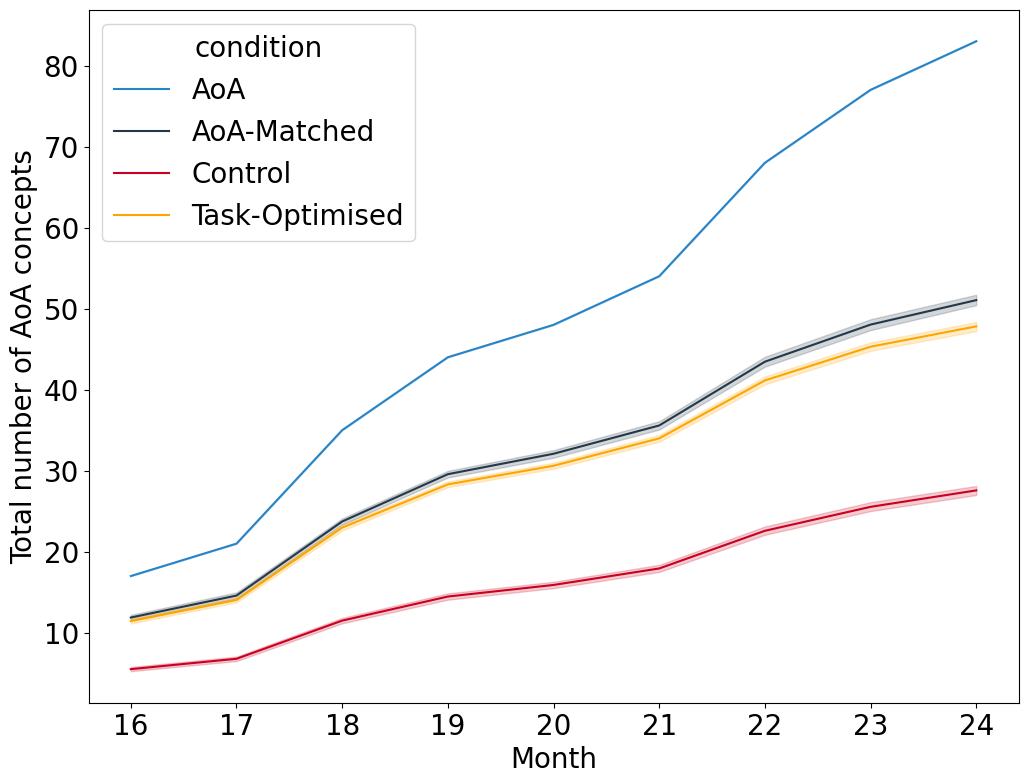

Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)


In [54]:
aoa = pd.read_csv(
            "../assets/aoa_data/aoa_data_EN.csv"
            )

all_seqs["aoa"] = [int(x in list(aoa["definition"])) for x in all_seqs["concept"]]

label_dict = {
        "Control": "Control",
        "AoA": "AoA",
        "matchAoA": "AoA-Matched",
        "taskOptimised": "Task-Optimised"
}

all_seqs["condition"] = [label_dict[x] for x in all_seqs["condition"]]

all_seq = all_seqs[
                    ["pid", "condition", "aoa", "month"]
                ].groupby(
                    ["pid", "condition", "month"]
                ).agg("sum").reset_index()
all_seq = all_seq.sort_values(["month", "condition"])
all_seq["csum"] = all_seq[
                        ["pid", "condition", "aoa"]
                    ].groupby(
                        ["pid", "condition"]
                    )["aoa"].cumsum()



palette = {
        "Control": "#ca0020",
        "AoA": "#2683C6",
        "AoA-Matched": "#253848",
        "Task-Optimised": "orange"
}



plt.figure(facecolor="white", figsize=(12,9))
sns.lineplot(data=all_seq, x="month", y="csum", hue="condition",
             palette=palette, err_style="band", ci=95)
plt.xlabel("Month")
plt.ylabel("Total number of AoA concepts")
plt.savefig("Figures/proportion_aoa.png")
plt.show()


all_s = all_seq.loc[all_seq["month"] == 24]
all_s["csum"] = all_s["csum"]/83

t_0 = stats.ttest_ind(
    all_s.loc[all_s["condition"] == "matchAoA", "csum"],
    all_s.loc[all_s["condition"] == "Control", "csum"])
print(t_0)

t_1 = stats.ttest_ind(
    all_s.loc[all_s["condition"] == "taskOptimised", "csum"],
    all_s.loc[all_s["condition"] == "Control", "csum"])
print(t_1)

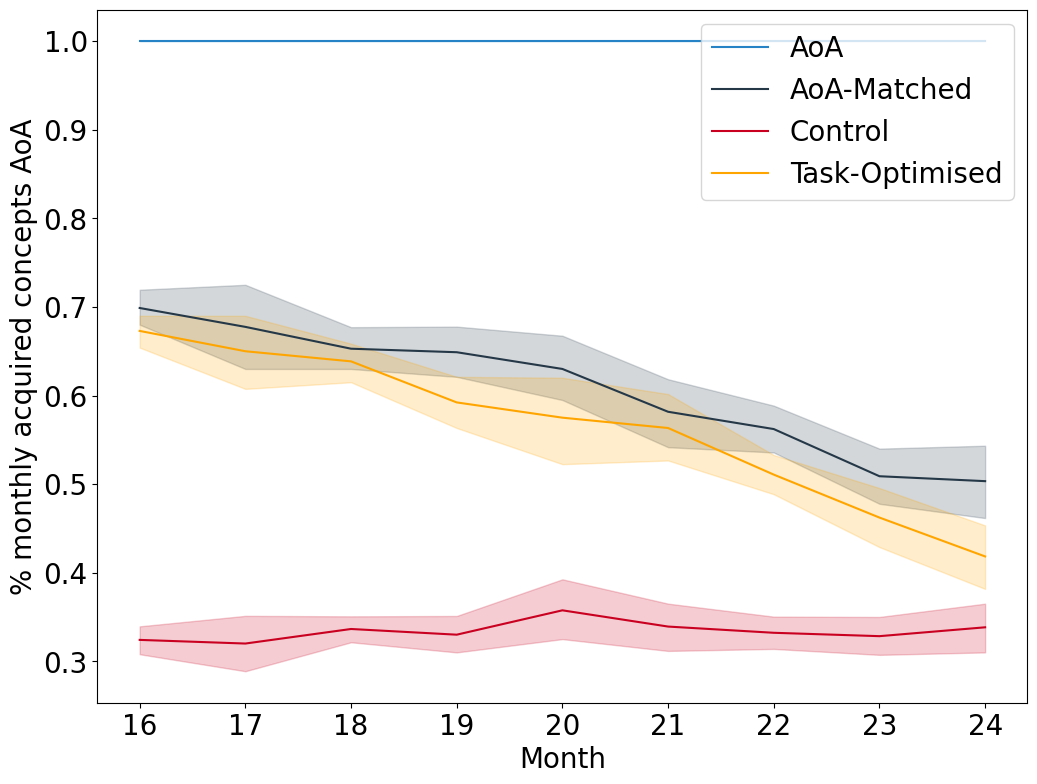

In [55]:
# AoA proportions
aoa_bymonth = all_seqs[
    ["pid", "month", "condition", "aoa"]
    ].groupby(
        ["condition", "pid", "month"]
        ).agg("mean")
#aoa_bymonth = aoa_bymonth.groupby(["month", "condition"]).agg(["mean", "std"]).reset_index()

plt.figure(facecolor="white", figsize=(12,9))
sns.lineplot(data = aoa_bymonth, x = "month", y="aoa",
             hue="condition", palette=palette)
plt.xlabel("Month")
plt.ylabel("% monthly acquired concepts AoA")
plt.legend(loc="upper right")
plt.savefig("Figures/AoA_pct_monthly.png")
plt.show()

In [56]:
new_cats = pd.read_csv("../assets/external_features/uncategorised_addn.csv",
                       index_col=0, header=0) # Categories
new_cats["category"] = [
                        "household" if x == "office"
                        else x for x in new_cats["category"]]
new_cats["category"] = [
                        "food_drink"
                        if x == "games_routines"
                        else x for x in new_cats["category"]]
new_cats = new_cats[["concept", "category"]].drop_duplicates()
new_cats = new_cats.rename(
    columns={"category":"new_category"}
)
cats = all_seqs.merge(new_cats[["new_category", "concept"]], on="concept")

old_cats = pd.read_csv("../assets/aoa_data/aoa_data_EN.csv",
                       index_col=0, header=0)
old_cats = old_cats.rename(
    columns={"category":"old_category",
             "definition":"concept"}
)
old_cats = old_cats[
                    ["concept", "old_category"]
                ].drop_duplicates()
cats = cats.merge(old_cats[
                        ["old_category", "concept"]
                    ], on="concept", how="left")
cats = cats[
            ["concept", "old_category", "new_category"]
            ].drop_duplicates()
cats["change"] = cats["old_category"] != cats["new_category"]


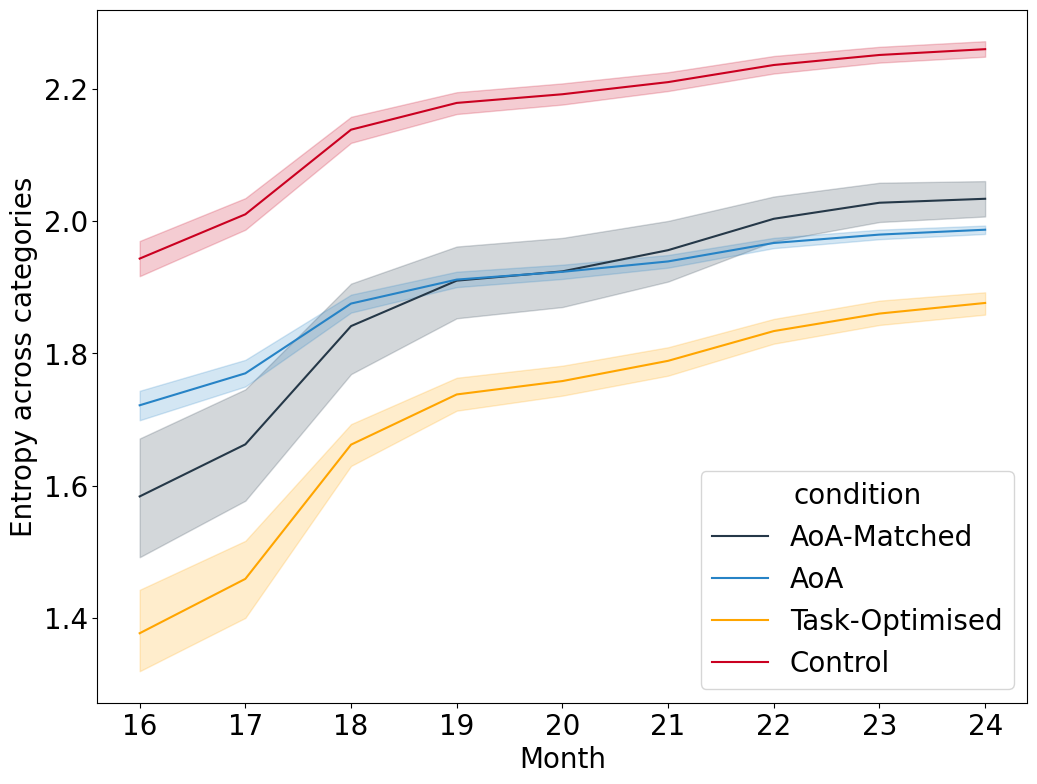

In [57]:
## Calculate within-month entropy
df = pd.read_csv("../assets/external_features/uncategorised_addn.csv",
                 index_col=0, header=0) # Categories
aoa = pd.read_csv(
            "../assets/aoa_data/aoa_data_EN.csv"
        )
aoa = aoa.loc[aoa["definition"].isin(vocab)]

df = df[["concept", "category"]]
df["category"] = [
                    "household"
                    if x == "office"
                    else x for x in df["category"]]
df["category"] = [
                    "food_drink"
                    if x == "games_routines"
                    else x for x in df["category"]]

c = df[["concept", "category"]].drop_duplicates()
c["aoa"] = [
            x in list(aoa["definition"])
            for x in c["concept"]]
cats = all_seqs.merge(c[["category", "concept"]], on="concept")

ent = analysis.get_response_entropy(cats, entropy="to_date")
ent = ent[
            ["pid",
             "condition",
             "entropy",
             "month"]
        ].drop_duplicates()

plt.figure(facecolor="white", figsize=(12,9))
sns.lineplot(x="month", y="entropy", hue="condition", data=ent,
                palette=palette)
plt.xlabel("Month")
plt.ylabel("Entropy across categories")
plt.savefig("Figures/Overall_entropy.png")
plt.show()




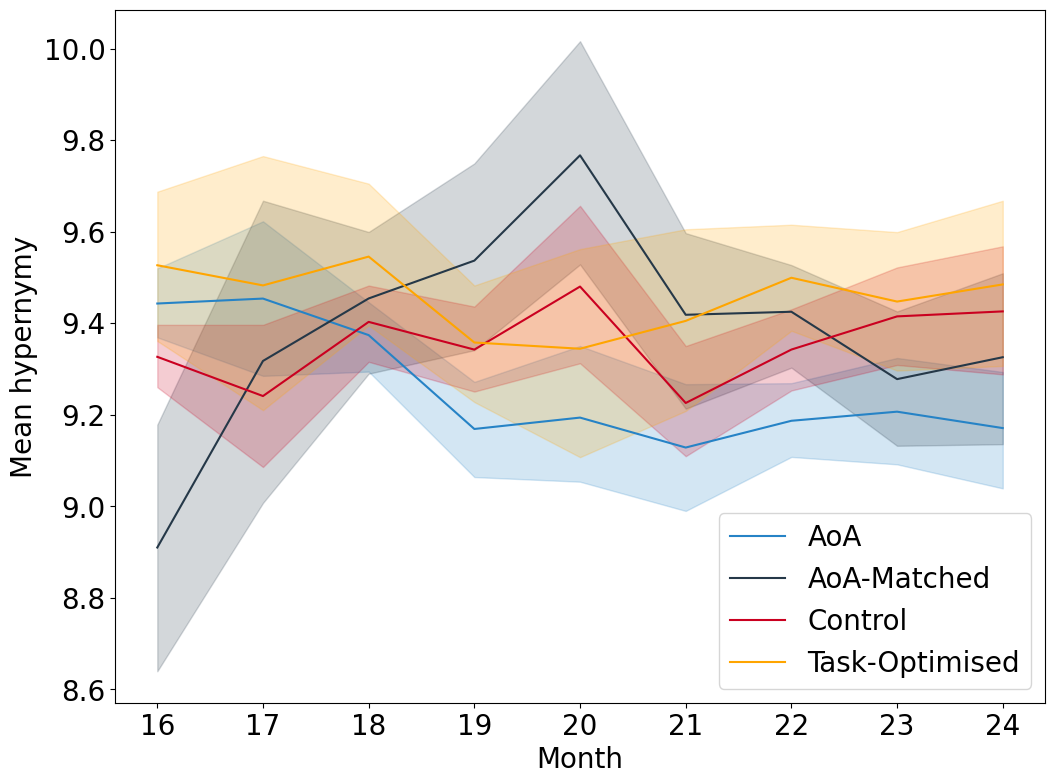

In [58]:
hypernymy = pd.read_csv("../assets/external_features/hypernymy.csv",
                        index_col=0)
hypernymy.columns = ["concept", "hypernymy"]

hypernymy = all_seqs.merge(hypernymy, on="concept")

    
hypernymy = hypernymy[
    ["condition", "pid", "month", "hypernymy"]
    ].groupby(["condition", "pid", "month"]).agg("mean")
#hypernymy= hypernymy.groupby(["condition", "month"]).agg(["mean", "std"]).reset_index()

plt.figure(facecolor="white", figsize=(12,9))
sns.lineplot(x="month", y="hypernymy",
             hue="condition", data=hypernymy, palette=palette)
plt.xlabel("Month")
plt.ylabel("Mean hypernymy")
plt.legend(loc="lower right")
plt.savefig("Figures/Hypernymy_over_time.png")
plt.show()


In [59]:

hypernymy = pd.read_csv("../assets/external_features/hypernymy.csv",
                        index_col=0)
hypernymy.columns = ["concept", "hypernymy"]

hypernymy = all_seqs.merge(hypernymy, on="concept")
hypernymy = hypernymy[
    ["condition", "pid", "month", "hypernymy"]
].groupby(["condition", "pid", "month"]).agg("mean").reset_index()

conds = []
betas = []
consts = []
pvals = []

for cond in hypernymy["condition"].unique():
    print("Condition = {}".format(cond))
    dat = hypernymy.loc[hypernymy["condition"] == cond]
    X = dat["month"]
    y = dat['hypernymy']
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    conds.append(cond)
    betas.append(est2.params["month"])
    pvals.append(est2.pvalues.loc["month"])
    consts.append(est2.params["const"])
    

print(conds, betas, pvals, consts)

Condition = AoA
                            OLS Regression Results                            
Dep. Variable:              hypernymy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     21.94
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           3.02e-06
Time:                        15:15:30   Log-Likelihood:                -2312.3
No. Observations:                1800   AIC:                             4629.
Df Residuals:                    1798   BIC:                             4640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0066      0.161    

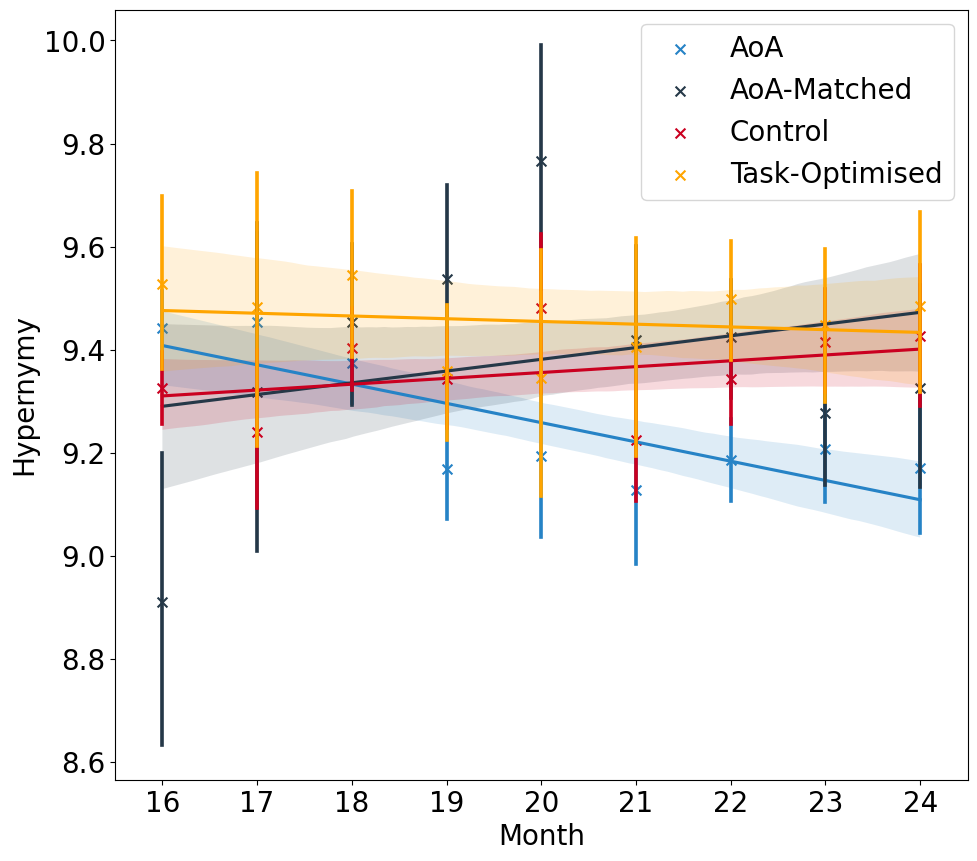

In [60]:
fig, ax = plt.subplots(figsize=(11,10))


color_dict = {
    "Control":"#ca0020",
    "AoA": "#2683C6",
    "Structural-Optimal": "orange",
    "Structural-MatchAoA": "#253848",
}

hypernymy["month"] = pd.to_numeric(hypernymy["month"])

for i, cond in enumerate(conds):
    sns.regplot(x="month", y="hypernymy",
                data=hypernymy.loc[hypernymy["condition"] == cond],
            x_estimator=np.mean, ax=ax, color=palette[cond], marker="x",label=cond,
                scatter_kws={"s":50, })
plt.xlim(15.5, 24.5)
plt.legend()
plt.xlabel("Month")
plt.ylabel("Hypernymy")
plt.savefig("Figures/Hypernymy_trends.png")
plt.show()


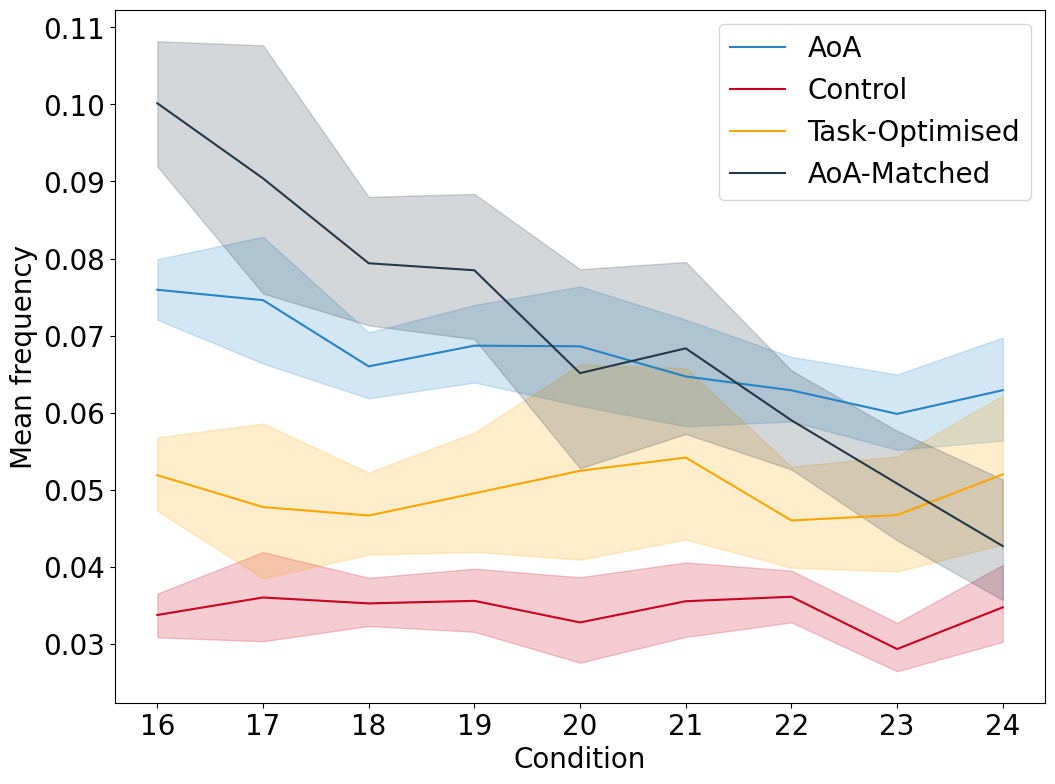

In [61]:
# Frequency based on condition

#### Repeat these analyses, but for the partitioned data
# Compare the structural to the optimal agent
labels = {
        "controlIncAoA": "Control",
        "AoA": "AoA",
        "synthProbIncAoA": "AoA-Matched",
        "synthOptIncAoA": "Task-Optimised"
}

df_control = pd.read_csv(
        "../results/sample_sequences/controlIncAoA_sequences.csv"
                        )
df_optimal = pd.read_csv(
        "../results/sample_sequences/synthOptIncAoA_sequences.csv"
                    )
df_structural = pd.read_csv(
        "../results/sample_sequences/synthProbIncAoA_sequences.csv"
                       )

all_seqs = pd.concat(
                        [df_aoa,
                         df_control,
                         df_optimal,
                         df_structural]
                    )
    
all_seqs = all_seqs.loc[all_seqs["month"] <= 24]

# Get log frequencies averaged across domains
img_cnt = pd.read_csv("../assets/external_features/img_freq_bbox.csv",
                      header=0, index_col=0)
# Map class IDs to labels
img_cnt = img_cnt.rename(columns={"wd":"LabelName", "count":"img_count"})
img_lab = pd.read_csv(
        "../assets/external_features/class-descriptions-boxable.csv",
        header=0)
img_lab = img_lab.rename(columns={"DisplayName":"wd"})
img_lab["concept"] = [x.lower() for x in img_lab["wd"]]

img_cnt = img_cnt.merge(img_lab, how="left", on="LabelName")
img_cnt = img_cnt.drop(columns="LabelName")

# Import wd frequencies
wd_cnt = pd.read_csv("../assets/external_features/unigram_freq.csv",
                     header=0, index_col=None)
wd_cnt = wd_cnt.rename(columns={"count":"wd_count", "word":"concept"})

# Merge frequencies
freqs = wd_cnt.merge(img_cnt, on="concept", how="outer")
freqs = freqs.dropna()

freqs = all_seqs.merge(freqs, on="concept")

freqs["img_count"] = freqs["img_count"]/np.max(freqs["img_count"])
freqs["wd_count"] = freqs["wd_count"]/np.max(freqs["wd_count"])

freqs["mean_count"] = (freqs["img_count"] + freqs["wd_count"])/2

freqs["condition"] = [labels[x] for x in freqs["condition"]]

plt.figure(facecolor="white", figsize=(12,9))
sns.lineplot(x="month", y="mean_count",
             hue="condition", data=freqs, palette=palette)
plt.xlabel("Condition")
plt.ylabel("Mean frequency")
plt.legend(loc="upper right")
plt.savefig("Figures/Frequency_trends_bycond_include.png")
plt.show()



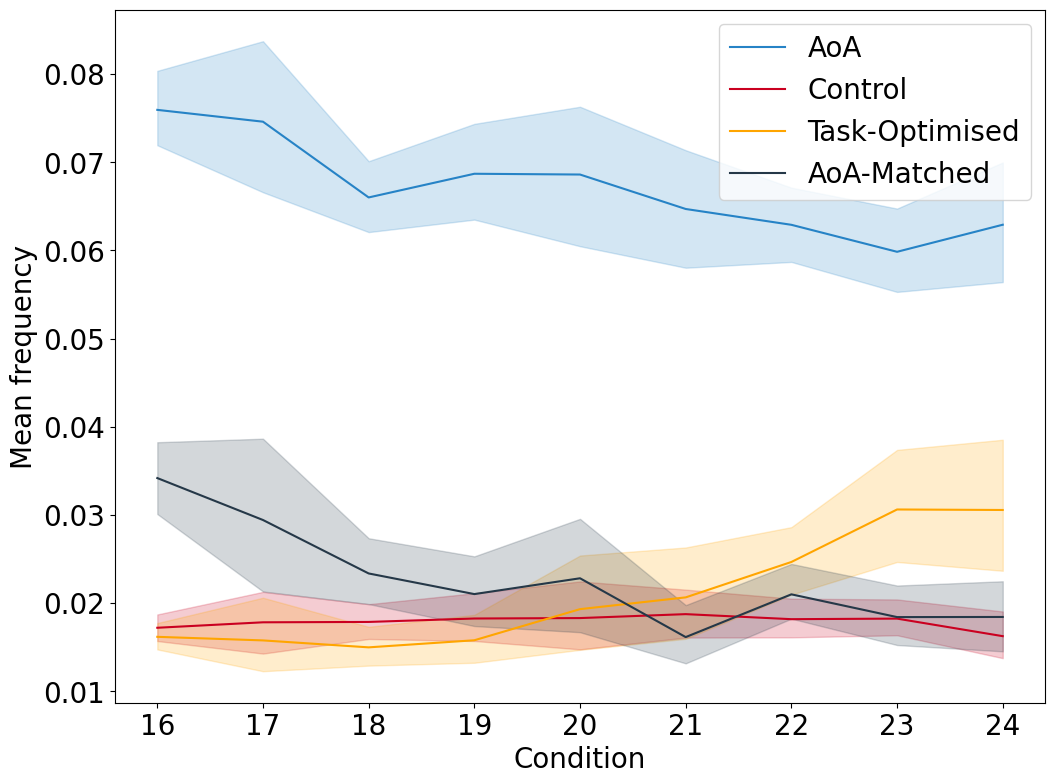

In [62]:
#### Repeat these analyses, but for the partitioned data
# Compare the structural to the optimal agent
labels = {
        "controlExcAoA": "Control",
        "AoA": "AoA",
        "synthProbExcAoA": "AoA-Matched",
        "synthOptExcAoA": "Task-Optimised"
}


df_control_exc = pd.read_csv(
                "../results/sample_sequences/controlExcAoA_sequences.csv")

df_optimal_exc = pd.read_csv(
                "../results/sample_sequences/synthOptExcAoA_sequences.csv")
                    
df_structural_exc = pd.read_csv(
                "../results/sample_sequences/synthProbExcAoA_sequences.csv")
                       

all_seqs_exc = pd.concat(
                        [df_aoa,
                         df_control_exc,
                         df_optimal_exc,
                         df_structural_exc]
                    )

all_seqs_exc["condition"] = [labels[x] for x in all_seqs_exc["condition"]]
    
all_seqs_exc = all_seqs_exc.loc[all_seqs_exc["month"] <= 24]


# Merge frequencies
freqs = wd_cnt.merge(img_cnt, on="concept", how="outer")
freqs = freqs.dropna()

freqs = all_seqs_exc.merge(freqs, on="concept")

freqs["img_count"] = freqs["img_count"]/np.max(freqs["img_count"])
freqs["wd_count"] = freqs["wd_count"]/np.max(freqs["wd_count"])

freqs["mean_count"] = (freqs["img_count"] + freqs["wd_count"])/2
print

plt.figure(facecolor="white", figsize=(12,9))
sns.lineplot(x="month", y="mean_count",
             hue="condition", data=freqs, palette=palette)
plt.xlabel("Condition")
plt.ylabel("Mean frequency")
plt.legend(loc="upper right")
plt.savefig("Figures/Frequency_trends_bycond_exclude.png")
plt.show()

